In [1]:
%load_ext autoreload
%autoreload all

In [2]:
from ptdalgorithms import Graph, SVGD, analyze_svgd_profile, set_theme, clear_cache
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colors
set_theme('dark')

%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'

# "iridis" color map (viridis without the deep purple)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

from functools import partial

import cProfile, pstats
profiler = cProfile.Profile()

In [3]:

def construct_rabbit_model(nr_rabbits=3):
    """
    Construct parameterized rabbit island model.

    State: [n_left, n_right]
    Transitions:
      - Jump: (n_l, n_r) → (n_l-1, n_r+1) at rate n_l * θ₀
      - Left flood: (n_l, n_r) → (0, n_r) at rate θ₁
      - Right flood: (n_l, n_r) → (n_l, 0) at rate θ₂

    Parameters:
      nr_rabbits: Number of rabbits starting on left island

    Returns:
      Graph with parameterized edges
    """
    graph = Graph(state_length=2)

    # Initial state: all rabbits on left
    initial_state = np.array([nr_rabbits, 0], dtype=np.int32)
    start = graph.starting_vertex()
    start.add_edge(graph.find_or_create_vertex(initial_state), 1.0)

    # Build state space
    index = 1
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()
        n_left, n_right = state[0], state[1]

        # Rabbit jumps left→right: rate = n_left * θ₀
        if n_left > 0 and n_right < nr_rabbits:
            child_state = np.array([n_left - 1, n_right + 1], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [float(n_left), 0.0, 0.0]  # Coefficients for [θ₀, θ₁, θ₂]
            )

        # Left island floods: rate = θ₁
        if n_left > 0:
            child_state = np.array([0, n_right], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [0.0, 1.0, 0.0]
            )

        # Right island floods: rate = θ₂
        if n_right > 0:
            child_state = np.array([n_left, 0], dtype=np.int32)
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0.0,  # base weight
                [0.0, 0.0, 1.0]
            )

        index += 1

    return graph


def build_exponential_graph():
    """
    Build single exponential distribution with parameterized rate.

    Returns:
        Graph with exponential distribution: S → [2] → [1]
        - S (state [0]) → [2] with probability 1.0 (initial transient state)
        - [2] → [1] with rate θ (parameterized, absorbing state)

    Note: Starting vertex has implicit state [0], so initial transient state
    must use a different state value (here [2]) to avoid duplication.

    The edge rate = base_weight + coefficients @ theta
    For single exponential: rate = 0.0 + 1.0 * theta[0] = theta[0]
    """
    g = Graph(state_length=1)
    start = g.starting_vertex()

    # Initial transient state [2] (can't use [0] as it conflicts with starting vertex)
    v2 = g.find_or_create_vertex([2])
    # Absorbing state [1]
    v1 = g.find_or_create_vertex([1])

    # Starting vertex → initial state (probability 1.0)
    start.add_edge(v2, 1.0)

    # Initial state → absorbing state (parameterized rate = theta[0])
    # Parameterized edge: rate = weight + edge_state @ theta
    # For single exponential: rate = 0.0 + [1.0] @ theta = theta[0]
    v2.add_edge_parameterized(v1, 0.0, [1.0])

    return g


In [4]:
#clear_cache()

In [5]:
np.random.seed(42)

# true_theta, construct_graph = [2.0], build_exponential_graph

nr_rabbits = 1
true_theta = [2.0, 3.0, 1.0]
n_obs = 500
n_particles = 20 * len(true_theta)
n_iterations = 1000
construct_graph = partial(construct_rabbit_model, nr_rabbits)

#############
# This is doing eliminating just for sampling - just for testing...
_graph = construct_graph()
_graph.update_parameterized_weights(true_theta)
observed_data = np.array(_graph.sample(n_obs))
#############

graph = construct_graph()
print(graph.vertices_length())



####################

# ADD A REWARD MATRIX AS INPUT TO ALLOW INPUT TO BE AN N-DIM ONE-HOT VECTOR OF TONS...
# I would like to allow the format of observable data taked by STGD() from an array of values, to a 2d array. In this case  it will be an array of arrays, where the inner arrays represent observations. Each observation has only a single non-zero value. 

# The indices of the second dimension of observed data will correspond to the second dimension of the specified reward matrix. If the second dimensions have length n, then the compiled pdf function should compute n marmginal pdf functions and evaluate each observation in accordance with its positions in the observation array.

# If the observations are a 1d array, computation should proceed as already implemented

####################

# 
#  of values. 
# 
#  to accept two-dimentional data the first dimention retpresents dataponts and the second represents 
# 
# (Array of arrays) observed_data 

4


INFO: loaded elimination trace from cache (b7bfba87bb01b722465f2a8076afdf57bc1dde741757c7c276e4ed2e7efdeb24): 19 operations, 4 vertices
INFO: loaded elimination trace from cache (b7bfba87bb01b722465f2a8076afdf57bc1dde741757c7c276e4ed2e7efdeb24)


In [6]:

parameterized_pdf = Graph.pmf_from_graph(
    graph,
    # discrete=False,
)

# test_theta = jnp.array(true_theta)
# test_times = jnp.array([0.5, 1.0, 1.5])
# test_pdf = pparameterized_pdfdf(test_theta, observed_data)
# print(test_pdf)


In [7]:



#learning_rate = 0.01
svgd = SVGD(
    parameterized_pdf, 
            observed_data, 
            theta_dim=len(true_theta),
            n_iterations=n_iterations,        
#            learning_rate=learning_rate,
            verbose=True,
)

: 

In [ ]:
def _pdf(theta, data, graph=None):
    graph.update_parameterized_weights(theta)
    return graph.pdf(data)

from functools import partial
parameterized_pdf = partial(_pdf, graph=graph)



array([0.91451997, 1.20600441, 2.05057879, 1.77732811, 1.5521309 ,
       0.27910802, 0.16619099, 2.39362773, 0.37496957, 0.24492468,
       0.67894543, 0.9025035 , 1.25953197, 0.09625888, 0.07803837,
       0.37576025, 2.8515582 , 0.90548771, 0.09463337, 0.25491159,
       0.38137561, 0.12685717, 2.68871125, 0.54119764, 2.98730469,
       1.90065348, 0.78338546, 0.84550271, 1.68938868, 2.10076055,
       2.03416249, 2.79215589, 2.35456456, 0.91149588, 2.88788081,
       2.91238437, 0.45378789, 0.01073883, 0.07084785, 1.32092136,
       0.33487267, 0.71001607, 0.82935721, 1.2103543 , 1.63785153,
       2.24169164, 2.29733179, 1.97790042, 0.27957754, 2.2786104 ,
       1.48856295, 0.09930279, 2.1875984 , 2.10076055, 1.03641552,
       0.78093564, 2.78044327, 1.88563223, 0.10000479, 0.97790826,
       2.13500767, 1.09570875, 0.4932186 , 0.26738115, 2.08387632,
       1.52283614, 0.16873172, 0.26310462, 0.00732903, 2.34491319,
       1.56403954, 2.2786104 , 1.49988215, 0.84550271, 0.29959

In [6]:
# %%monitor

# svgd.fit(return_history=True)

In [17]:
profiler.enable()
svgd.fit(return_history=True)
profiler.disable()


Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 500
  Prior: standard normal
Running SVGD: 1000 steps, 60 particles



SVGD complete!
Posterior mean: [ 1.80740124 -0.20199092 -0.04685333]
Posterior std:  [3.96488813 1.0742883  0.80008841]


In [18]:
stats = pstats.Stats(profiler)
analysis = analyze_svgd_profile(stats)

SVGD Performance Profile Analysis

Total time: 85330.958s

Time Distribution:
--------------------------------------------------------------------------------
  Core Computation:    5614.850s  (  6.6%)
  JAX Overhead:        60470.898s  ( 70.9%)
  SVGD Algorithm:      8773.522s  ( 10.3%)
  NumPy Operations:       0.000s  (  0.0%)
  Other:               9936.396s  ( 11.6%)

JAX Overhead Breakdown:
--------------------------------------------------------------------------------
  vmap/pmap            15285.256s  ( 25.3% of JAX,  17.9% total)
  Other JAX            14738.447s  ( 24.4% of JAX,  17.3% total)
  Dispatch             12227.066s  ( 20.2% of JAX,  14.3% total)
  Callbacks/FFI        9097.319s  ( 15.0% of JAX,  10.7% total)
  Primitives           5937.572s  (  9.8% of JAX,   7.0% total)
  Tracing              3057.867s  (  5.1% of JAX,   3.6% total)
  Array ops             127.371s  (  0.2% of JAX,   0.1% total)

Top Computation Functions:
----------------------------------------

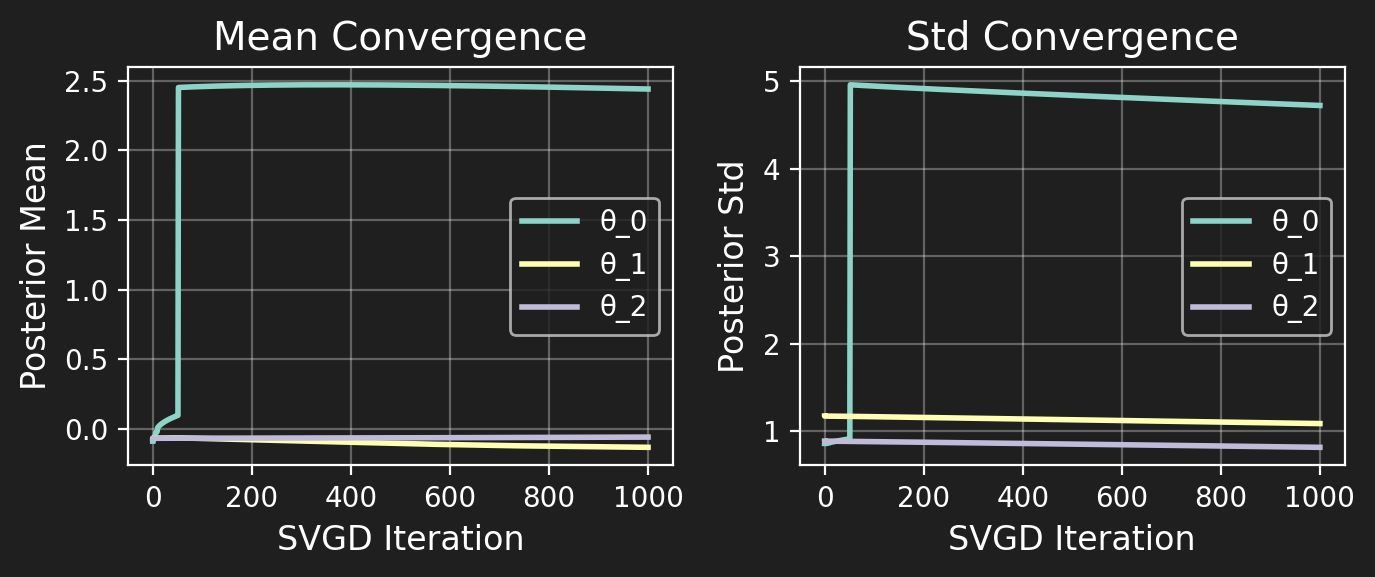

In [7]:
svgd.plot_convergence() ;

(<Figure size 700x300 with 2 Axes>,
 array([<Axes: title={'center': 'Mean Convergence'}, xlabel='SVGD Iteration', ylabel='Posterior Mean'>,
        <Axes: title={'center': 'Std Convergence'}, xlabel='SVGD Iteration', ylabel='Posterior Std'>],
       dtype=object))

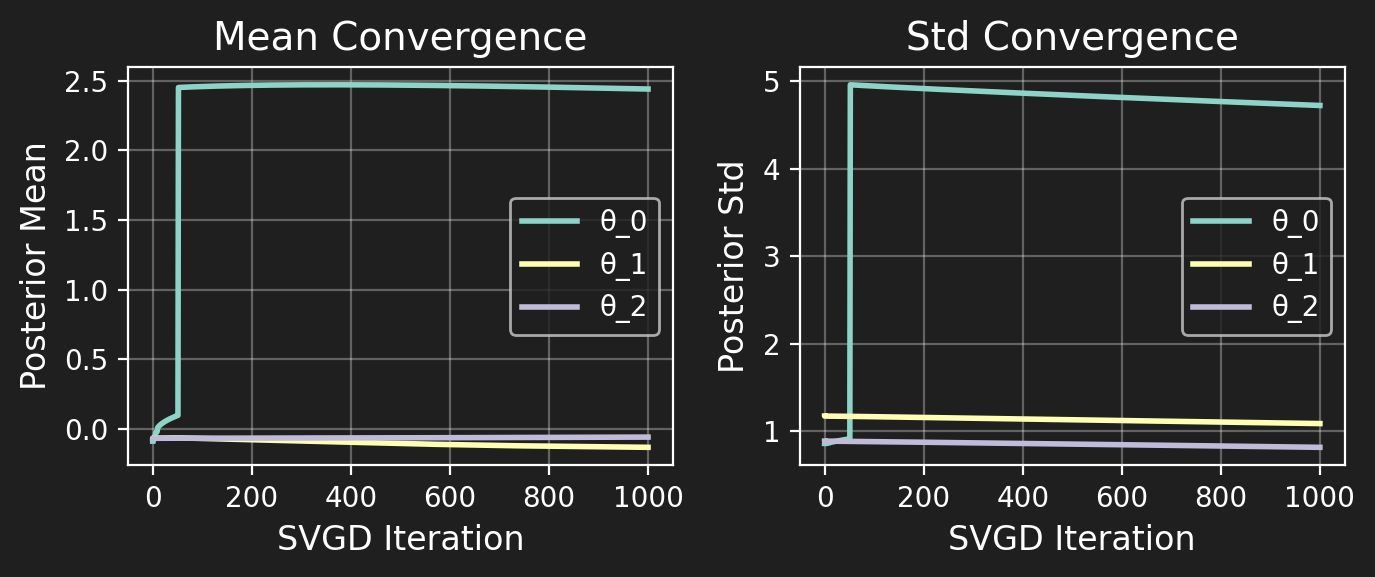

In [9]:
svgd.plot_convergence()

In [ ]:
! ls ../../galleries/

_build                   c_api                    numpy.css
_extensions              custom-dark.scss         numpy.theme
_freeze                  custom.scss              objects.txt
_inv                     galleries                pages
_quarto.yml              index.qmd                r_api
api                      logo.png                 styles.css
autodoc.mustache         numpy-dark.theme
banner.png               numpy-navbar-sidebar.css


/Users/kmt/PtDAlgorithms/.pixi/envs/default/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


60
60
60


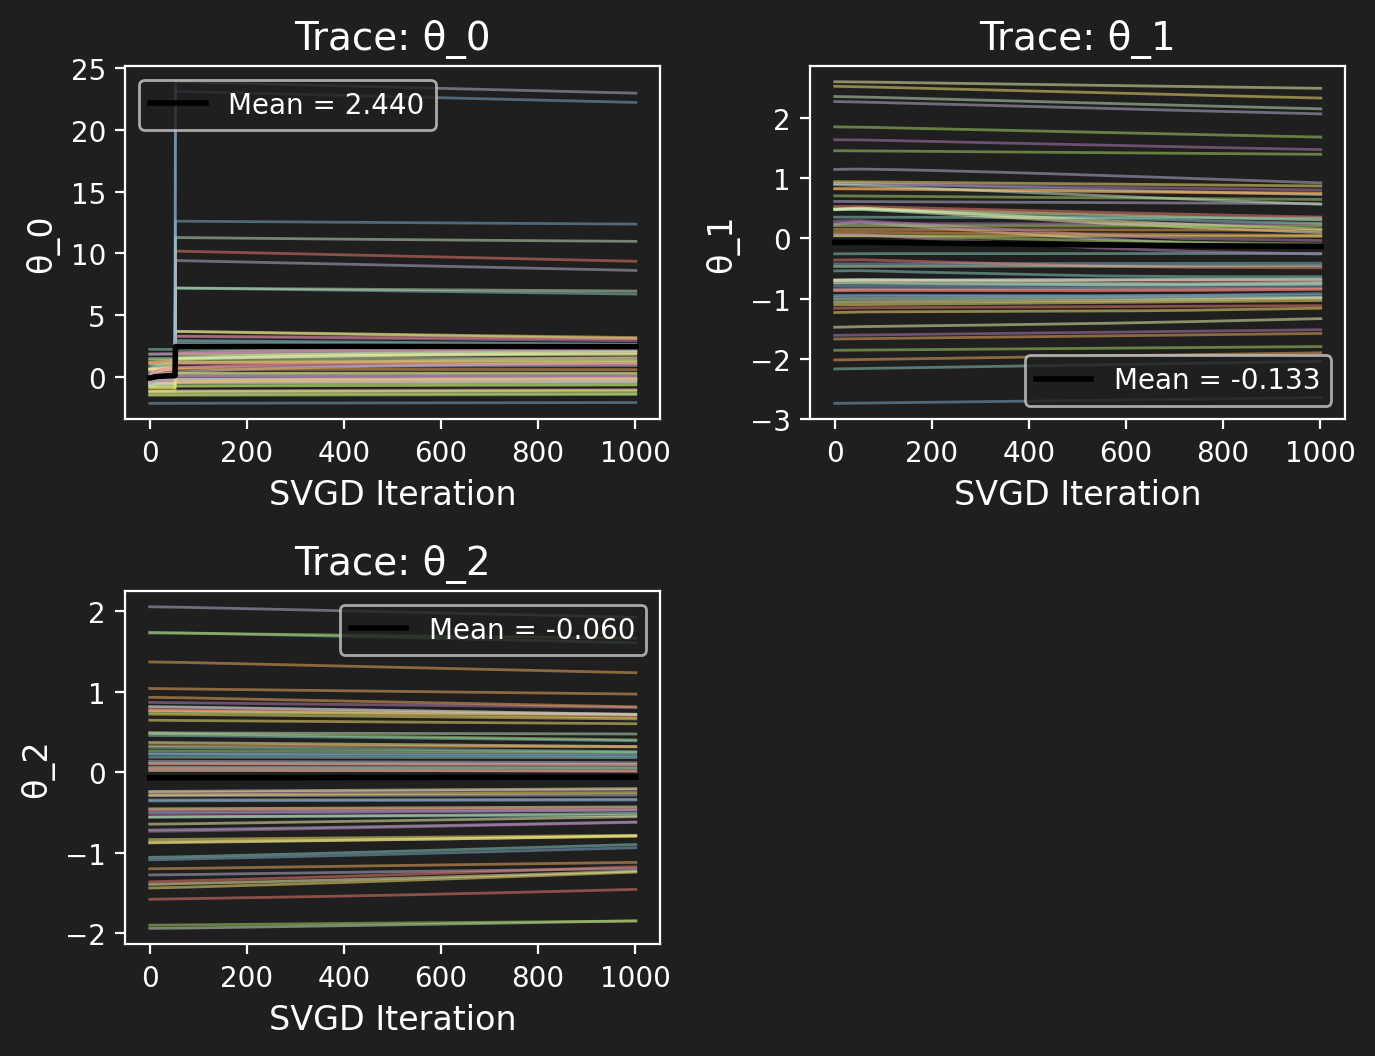

In [14]:
fig, axes = svgd.plot_trace()
fig.savefig('../../galleries/examples/images/svgd_convergence.webp', format='webp')

In [9]:
svgd.summary()

SVGD Inference Summary
Number of particles: 60
Number of iterations: 1000
Parameter dimension: 3

Posterior estimates:
  θ_0: 136.4124 ± 128.4685
       95% CI: [-29.4463, 352.3441]
  θ_1: 1633.8782 ± 986.7968
       95% CI: [-744.5340, 3198.3957]
  θ_2: 91.2288 ± 96.7373
       95% CI: [-107.4353, 276.1241]


In [ ]:
#svgd.animate(thin=50)

In [8]:
svgd.plot_pairwise(true_theta=true_theta,
                   # param_names=['jump', 'flood_left', 'flood_right'],
    show_transformed=True,
                   ) ;                   

RuntimeError: Must call fit() before plotting

In [ ]:
anim = svgd.animate_pairwise(
    true_theta=[2.0, 3.0, 2.0],
    param_names=['jump', 'flood_left', 'flood_right'],
    thin=20,
    show_transformed=True,
)
anim  # Display in Jupyter

[INFO] Animation.save using <class 'matplotlib.animation.HTMLWriter'>
[INFO] figure size in inches has been adjusted from 9.0 x 6.8999999999999995 to 9.0 x 6.9


In [ ]:
results = svgd.get_results()
results.keys()

dict_keys(['particles', 'theta_mean', 'theta_std', 'history'])